In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import zipfile
nltk.download('wordnet')
from nltk.stem.isri import ISRIStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
with zipfile.ZipFile('/content/gdrive/MyDrive/dialect_dataset.csv.zip', 'r') as zip_ref:
    zip_ref.extractall()

with zipfile.ZipFile('/content/gdrive/MyDrive/messages.csv.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
df1=pd.read_csv('/content/gdrive/MyDrive/dialect_dataset.csv.zip')
df1

,id,dialect
0,1175358310087892992,IQ
1,1175416117793349632,IQ
2,1175450108898565888,IQ
3,1175471073770573824,IQ
4,1175496913145217024,IQ
...,...,...
458192,1019484980282580992,BH
458193,1021083283709407232,BH
458194,1017477537889431552,BH
458195,1022430374696239232,BH


In [ ]:
df2=pd.read_csv('/content/gdrive/MyDrive/messages.csv.zip',lineterminator='\n')
df2

,Unnamed: 0,0
0,1.175358e+18,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .
1,1.175416e+18,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...
2,1.175450e+18,@KanaanRema مبين من كلامه خليجي
3,1.175471e+18,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐
4,1.175497e+18,@hmo2406 وين هل الغيبه اخ محمد 🌸🌺
...,...,...
458656,1.057419e+18,@mycousinvinnyys @hanyamikhail1 متهيالي دي شكو...
458657,1.055620e+18,@MahmoudWaked7 @maganenoo في طريق مطروح مركز ب...
458658,NaN,0
458659,1.057419e+18,@mycousinvinnyys @hanyamikhail1 متهيالي دي شكو...


In [ ]:
df2 = df2.rename(columns={"Unnamed: 0": "id"})
df2 = df2.rename(columns={"0": "tweets"})
df2

,id,tweets
0,1.175358e+18,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .
1,1.175416e+18,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...
2,1.175450e+18,@KanaanRema مبين من كلامه خليجي
3,1.175471e+18,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐
4,1.175497e+18,@hmo2406 وين هل الغيبه اخ محمد 🌸🌺
...,...,...
458656,1.057419e+18,@mycousinvinnyys @hanyamikhail1 متهيالي دي شكو...
458657,1.055620e+18,@MahmoudWaked7 @maganenoo في طريق مطروح مركز ب...
458658,NaN,0
458659,1.057419e+18,@mycousinvinnyys @hanyamikhail1 متهيالي دي شكو...


In [ ]:
df = pd.merge(df1, df2, on='id')


In [ ]:
df = df.drop(columns=['id'])
df

,dialect,tweets
0,IQ,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .
1,IQ,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...
2,IQ,@KanaanRema مبين من كلامه خليجي
3,IQ,@HAIDER76128900 يسلملي مرورك وروحك الحلوه💐
4,IQ,@hmo2406 وين هل الغيبه اخ محمد 🌸🌺
...,...,...
458196,BH,@Al_mhbaa_7 مبسوطين منك اللي باسطانا😅
458197,BH,@Zzainabali @P_ameerah والله ماينده ابش يختي
458198,BH,@Al_mhbaa_7 شو عملنا لك حنا تهربي مننا احنا مس...
458199,BH,@haneenalmwla الله يبارك فيها وبالعافيه 😋😋😋


In [ ]:
df['dialect'].unique()

array(['IQ', 'LY', 'QA', 'PL', 'SY', 'TN', 'JO', 'MA', 'SA', 'YE', 'DZ',
       'EG', 'LB', 'KW', 'OM', 'SD', 'AE', 'BH'], dtype=object)

In [ ]:
len(df['dialect'].unique())

18

# preprocessing

In [ ]:
classes = {
'EG': 'EG',
'DZ': 'AF',
'TN': 'AF',
'LY': 'AF',
'MA': 'AF',
'JO': 'SHAM',
'LB': 'SHAM',
'PL': 'SHAM',
'SY': 'SHAM',
'IQ': 'IQ',
'KW': 'KJ',
'SA': 'KJ',
'AE': 'KJ',
'OM': 'KJ',
'QA': 'KJ',
'YE': 'YE',
'SD': 'AF',
'BH': 'KJ'
}
df.loc[:, 'dialect']=df['dialect'].replace(classes)

In [ ]:
df=df.drop_duplicates()

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.isnull().sum()

dialect    0
tweets     0
dtype: int64

In [ ]:
!pip install tashaphyne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.5/251.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 10.8 MB/s eta 0:00:00


In [ ]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
from tashaphyne.stemming import ArabicLightStemmer

import nltk
nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)

    tokens = nltk.word_tokenize(text)

    stop_words = set(stopwords.words('arabic'))
    tokens = [token for token in tokens if token not in stop_words]


    stemmer = ArabicLightStemmer()
    tokens = [stemmer.light_stem(token) for token in tokens]

    processed_text = ' '.join(tokens)

    return processed_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df.tweets = df.tweets.apply(lambda x: preprocess_text(x))

<ipython-input-17-0d91b05ae58b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.tweets = df.tweets.apply(lambda x: preprocess_text(x))


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['dialect'])

X=df['tweets'].values
from keras.utils import to_categorical

y = to_categorical(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.2,random_state=2, stratify=y)


# DL

In [ ]:
import tensorflow as tf
import numpy as np
from keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding,SimpleRNN

In [ ]:
def plt_cm(model, x_test, y_test):

    classes_names = ['KJ','SHAM','AF','EG','IQ','YE']
    y_pred = model.predict(x_test)
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=classes_names,
                yticklabels=classes_names)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual class', fontsize=12)
    plt.ylabel('Predicted class', fontsize=12)

In [ ]:
embedding_dim = 100 #hyperparameter
max_length = 100 #hyperparameter
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1


In [ ]:
X_train_tokens =  tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_tokens, maxlen=max_length)
X_test_padded = pad_sequences(X_test_tokens, maxlen=max_length)
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(256))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          21434500  
                                                                 
 lstm_1 (LSTM)               (None, 256)               365568    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 6)                 390       
                                                                 
Total params: 21841610 (83.32 MB)
Trainable params: 21

In [ ]:
history = model.fit(X_train_padded, y_train, epochs=30, batch_size=64, validation_split=0.15, callbacks=[early_stopping])

Epoch 1/30
4869/4869 [==============================] - 140s 28ms/step - loss: 0.9373 - accuracy: 0.6638 - val_loss: 0.8284 - val_accuracy: 0.7083
Epoch 2/30
4869/4869 [==============================] - 80s 16ms/step - loss: 0.6721 - accuracy: 0.7687 - val_loss: 0.8125 - val_accuracy: 0.7156
Epoch 3/30
4869/4869 [==============================] - 81s 17ms/step - loss: 0.5082 - accuracy: 0.8240 - val_loss: 0.8923 - val_accuracy: 0.7065
Epoch 4/30
4869/4869 [==============================] - 92s 19ms/step - loss: 0.4026 - accuracy: 0.8575 - val_loss: 0.9849 - val_accuracy: 0.7031
Epoch 5/30
4869/4869 [==============================] - 83s 17ms/step - loss: 0.3405 - accuracy: 0.8770 - val_loss: 1.1280 - val_accuracy: 0.6950


In [ ]:
loss, accuracy=model.evaluate(X_test_padded,y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

2864/2864 [==============================] - 13s 5ms/step - loss: 0.8133 - accuracy: 0.7149
Test Loss: 0.8132795691490173
Test Accuracy: 0.7148734331130981


In [ ]:
lr = model.optimizer.learning_rate.numpy()
lr

0.001

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Predict labels for the test set
import numpy as np
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

2864/2864 [==============================] - 10s 3ms/step


In [ ]:
classes_names = ['KJ','SHAM','AF','EG','IQ','YE']
report = classification_report(y_test_classes, y_pred_classes, target_names=classes_names)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

          KJ       0.70      0.61      0.65     17580
        SHAM       0.73      0.74      0.73     11527
          AF       0.63      0.40      0.49      3100
          EG       0.73      0.84      0.78     34343
          IQ       0.70      0.69      0.70     23105
          YE       0.57      0.09      0.16      1985

    accuracy                           0.71     91640
   macro avg       0.68      0.56      0.59     91640
weighted avg       0.71      0.71      0.71     91640



2864/2864 [==============================] - 16s 6ms/step


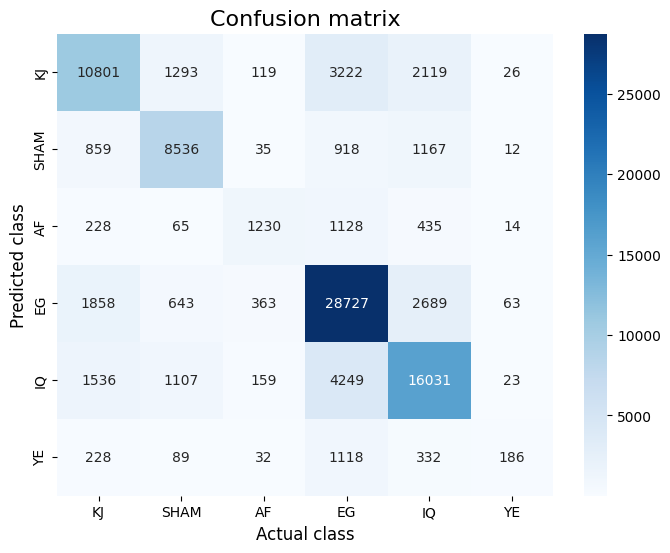

In [ ]:
import matplotlib.pyplot as plt
plt_cm(model, X_test_padded, y_test)

In [ ]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
